In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True" 

In [3]:
IMAGE_PATH = 'image_03.png'
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1" 

In [4]:
def preprocess_image(image_path):
    '''Loads the image given make it ready for 
       the model
       Args:
         image_path: Path to the image file
    '''
    image = tf.image.decode_image(tf.io.read_file(image_path))
    if image.shape[-1] == 4:
        image = image[...,:-1]
    size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
    image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
    image = tf.cast(image,tf.float32)
    return tf.expand_dims(image,0)

In [5]:
def save_image(image,filename):
    ''' 
    Saves unscaled Tensor Images
    image: 3D image Tensor
    filename: Name of the file to be saved
   '''
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save('%s.jpg' % filename)
    print('Saved as %s.jpg' % filename)

In [6]:
%matplotlib inline
def plot_image(image,title=''):
    ''' 
   plots the Image tensors
   image: 3D image Tensor
   title: Title for plot
   '''
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

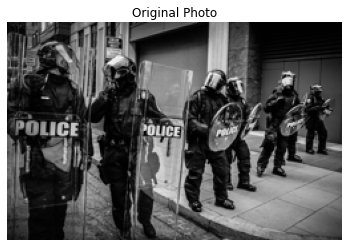

In [7]:
model = hub.load(SAVED_MODEL_PATH)
load_image = preprocess_image(IMAGE_PATH)
# plot original image
plot_image(tf.squeeze(load_image),title='Original Photo')

Time taken to complete process: 8.591197


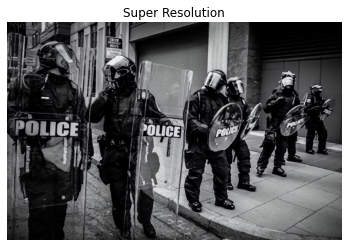

In [8]:
# Start Performing resolution 
start = time.time()
super_image = model(load_image)
super_image = tf.squeeze(super_image)
print('Time taken to complete process: %f'%(time.time() - start))
#plot the output image 
plot_image(tf.squeeze(super_image),'Super Resolution')

In [9]:
def downscale_image(image):
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")
    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))
    lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image 

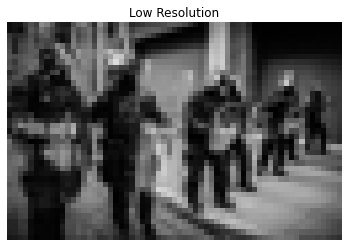

In [10]:
hr_image = preprocess_image(IMAGE_PATH)
lr_image = downscale_image(tf.squeeze(hr_image))
plot_image(tf.squeeze(lr_image), title="Low Resolution") 

In [11]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start)) 

Time Taken: 2.229002


PSNR Achieved: 21.098721


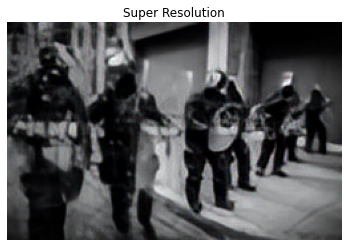

In [12]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 21.098721


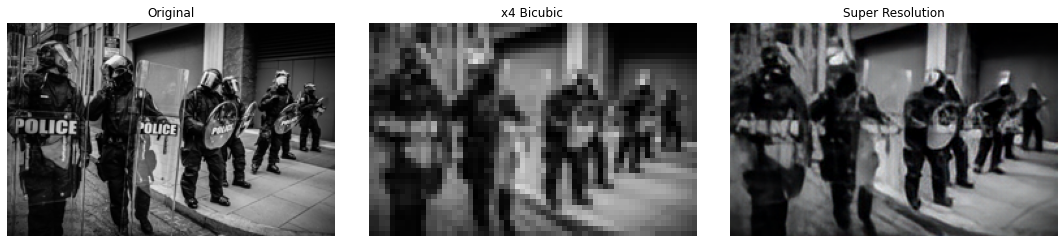

In [13]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), title="Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)